$x$ is given in the output file as a normalized momentum: $$ p=x\cdot m_e\cdot c$$ 
The definition of momentum (for electrons) is: $$p=\frac{m_ev}{\sqrt{1-\frac{v^2}{c^2}}}$$
To get the momentum $p$ we have to multiply $x$ with $m_ec$ first. We can calculate $v^2$ from the first two equations: $$v^2=\frac{p^2c^2}{p^2+m_e^2c^2} $$
The kinetic energy is: $$K=m_ec^2\Bigg( \frac{1}{1-\frac{v^2}{c^2}}-1\Bigg) $$
For getting the kinetic energy in electronvolts, we have to divide $K$ by the elemental charge.


In [225]:
import numpy as np
import scipy.constants
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import datetime
import math
import h5py
import os

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator


# matplotlib initial settings
# use plt.tight_layout() for matplotlib to not cut off labels at the edge of figures
plt.rcParams.update({'font.size': 18})
matplotlib.rc('image', cmap='inferno')


class DistributionDREAMOutput:
    def __init__(self, filename, plotfoldername):
        self.filename = filename
        self.plotfoldername = plotfoldername
        f = h5py.File(filename, "r")
        self.timegrid = f["grid/t"][()]
        self.number_of_timesteps = len(self.timegrid) - 1
        self.timestep = f["grid/t"][()][1]
        self.radialgrid = f["grid/r"][()]
        self.radial_step = f["grid/dr"][()]
        self.major_radius = f["settings/radialgrid/R0"][()]
        self.a = f["settings/radialgrid/a"][()]
        self.minor_radius = self.major_radius / self.a
        self.momentumgrid = f["grid/hottail/p1"][()]  # in m_e*c normalized momentum
        self.pitchgrid = f["grid/hottail/p2"][()]  # in radians?
        self.distribution = f["eqsys/f_hot"][()]  # time; radii; pitch; momentum
        self.angle_avg_distr = np.sum(self.distribution, 2)
        if not os.path.exists("./" + self.plotfoldername):
            os.mkdir(self.plotfoldername)
        
        # Some constants
        m_e = scipy.constants.m_e  # electron mass
        e = scipy.constants.e  # elemental charge
        c = scipy.constants.c  # speed of light
        
        # Calculating the energies from the momentum grid
        self.real_momentum = self.momentumgrid * m_e * c
        self.velocity_squared = (self.real_momentum ** 2 * c ** 2) / (self.real_momentum ** 2 + m_e ** 2 * c ** 2)
        self.kinetic_energy = m_e * c ** 2 * ((1 / ( 1 - (self.velocity_squared / c ** 2))) - 1)
        self.energy_grid_electronvolts = self.kinetic_energy / e
        
        # Only for testing purposes
        # self.distribution[0, 19, 1:3, -50:-1] = 1e25
       
    
    def __str__(self):
        return f"Electron momentum and pitch distribution object from the file {self.filename}\n"
    
    
    def info(self):
        print("Number of saved timesteps: " + str(data.number_of_timesteps))
        print("Save timestep (dt): " + str(data.timestep * 1000) + " ms")
        print("Simulation time: " + str(data.timegrid[-1] * 1000) + " ms")
        print("Number of radial grid cells: " + str(len(data.radialgrid)))
        print("Radial step (dr): " + str(data.radial_step[1] - data.radial_step[0]) + " m")
        print("Minor radius: " + str(data.minor_radius) + " m")
        print("Number of momentum grid cells: " + str(len(data.momentumgrid)))
        print("Number of pitch angle grid cells: " + str(len(data.pitchgrid)))
    
    
    def plot_2D_momentum(self, at_timestep=0, at_radial_cell=0, from_momentum_cell=0, to_momentum_cell=-1, save=False):
        fig = plt.figure(figsize=[15,7])
        data_to_plot = self.distribution[at_timestep, at_radial_cell, :, from_momentum_cell:to_momentum_cell]
        
        if data_to_plot.min() < 1e10:
            vmin = 1e10
        else:
            vmin = data_to_plot.min()
            
        im = plt.pcolormesh(self.momentumgrid[from_momentum_cell:to_momentum_cell], self.pitchgrid, 
                            data_to_plot, norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))
        axes = plt.gca()
        axes.set_facecolor('black')
        cbar = fig.colorbar(im, ax=axes)

        cbar.set_label(r"Electron distribution [1/m$^3$]")
        plt.title("Momentum and pitch distribution of electrons")
        plt.ylabel("Pitch angle")
        plt.xlabel(r"Momentum normalized to $m_ec$")
        plt.tight_layout()
        
        if save == True:
            now = datetime.datetime.now()
            date_time = now.strftime("_%Y-%m-%d_%Hh-%Mm-%Ss")
            plt.savefig(self.plotfoldername + "2D_momentum_at_radial_cell_" + 
                        str(at_radial_cell) + "_at_timestep_" + str(at_timestep) +
                        date_time + ".png", dpi=150)
         
        
    def plot_2D_energy(self, at_timestep=0, at_radial_cell=0, from_energy_cell=0, to_energy_cell=-1, save=False):
        fig = plt.figure(figsize=[15,7])
        data_to_plot = self.distribution[at_timestep, at_radial_cell, :, from_energy_cell:to_energy_cell]
        
        if data_to_plot.min() < 1e10:
            vmin = 1e10
        else:
            vmin = data_to_plot.min()
            
        im = plt.pcolormesh(self.energy_grid_electronvolts[from_energy_cell:to_energy_cell] / 1000, self.pitchgrid, 
                            data_to_plot, norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))
        axes = plt.gca()
        axes.set_facecolor('black')
        cbar = fig.colorbar(im, ax=axes)

        cbar.set_label(r"Electron distribution [1/m$^3$]")
        plt.title("Energy and pitch distribution of electrons")
        plt.ylabel("Pitch angle")
        plt.xlabel(r"Energy [keV]")
        plt.tight_layout()
        
        if save == True:
            now = datetime.datetime.now()
            date_time = now.strftime("_%Y-%m-%d_%Hh-%Mm-%Ss")
            plt.savefig(self.plotfoldername + "2D_energy_at_radial_cell_" + 
                        str(at_radial_cell) + "_at_timestep_" + str(at_timestep) +
                        date_time + ".png", dpi=150)
         
        
    def plot_angle_avg(self, at_timestep=0, at_radial_cell=0, from_momentum_cell=0, to_momentum_cell=-1, 
                       save=False):
        fig = plt.figure(figsize=[15,7])
        data_to_plot = self.angle_avg_distr[at_timestep, at_radial_cell, from_momentum_cell:to_momentum_cell]
        plot = plt.scatter(self.momentumgrid[from_momentum_cell:to_momentum_cell], data_to_plot)
        
        axes = plt.gca()
        axes.set_facecolor('white')
        axes.set_xticks(self.momentumgrid[from_momentum_cell:to_momentum_cell], minor=True)
        axes.set_axisbelow(True)
        axes.xaxis.grid(True, which='minor', linestyle="--")
        axes.yaxis.grid(True, which="both")
        axes.set_yscale("log")
        
        plt.title("Angle averaged momentum distribution")
        plt.ylabel(r"Electron distribution [1/m$^3$]")
        plt.xlabel(r"Momentum normalized to $m_ec$")
        plt.tight_layout()
        
        if save == True:
            plt.savefig(self.plotfoldername + "angle_avg_momentum_at_radial_cell_" + 
                        str(at_radial_cell) + "_at_timestep_" + str(at_timestep) +
                        date_time + ".png", dpi=150) 
         
        
    def plot_momentum_at_specific_pitch(self, at_timestep=0, at_radial_cell=0, 
                                        from_momentum_cell=0, to_momentum_cell=-1, 
                                        pitch_cell=0, save=False):
        fig = plt.figure(figsize=[15,7])
        data_to_plot = self.distribution[at_timestep, at_radial_cell, pitch_cell, from_momentum_cell:to_momentum_cell]
        plot = plt.scatter(self.momentumgrid[from_momentum_cell:to_momentum_cell], data_to_plot)
        
        axes = plt.gca()
        axes.set_facecolor('white')
        axes.set_xticks(self.momentumgrid[from_momentum_cell:to_momentum_cell], minor=True)
        axes.set_axisbelow(True)
        axes.xaxis.grid(True, which='minor', linestyle="--")
        axes.yaxis.grid(True, which="both")
        axes.set_yscale("log")
        
        plt.title("Momentum distribution at pitch cell #" + str(pitch_cell))
        plt.ylabel(r"Electron distribution [1/m$^3$]")
        plt.xlabel(r"Momentum normalized to $m_ec$")
        plt.tight_layout()
        
        if save == True:
            plt.savefig(self.plotfoldername + "momentum_(pitch_cell_" + str(pitch_cell) + "_at_radial_cell_" + 
                        str(at_radial_cell) + "_at_timestep_" + str(at_timestep) +
                        date_time + ".png", dpi=150)  
         
        
    def plot_pitch_at_specific_momentum(self, at_timestep=0, at_radial_cell=0, 
                       momentum_cell=0, save=False):
        fig = plt.figure(figsize=[15,7])
        data_to_plot = self.distribution[at_timestep, at_radial_cell, :, momentum_cell]
        plot = plt.scatter(self.pitchgrid, data_to_plot)
        
        axes = plt.gca()
        axes.set_facecolor('white')
        axes.set_xticks(self.pitchgrid, minor=True)
        axes.set_axisbelow(True)
        axes.xaxis.grid(True, which='minor', linestyle="--")
        axes.yaxis.grid(True, which="both")
        axes.set_yscale("linear")
        
        plt.title("Pitch distribution at momentum cell #" + str(momentum_cell))
        plt.ylabel(r"Electron distribution [1/m$^3$]")
        plt.xlabel("Pitch angle")
        plt.tight_layout()
        
        if save == True:
            plt.savefig(self.plotfoldername + "pitch_(momentum_cell_" + str(momentum_cell) + "_at_radial_cell_" + 
                        str(at_radial_cell) + "_at_timestep_" + str(at_timestep) +
                        date_time + ".png", dpi=150)  
            
    

In [226]:
foldername = "DEMO_8e/"
filename = "output_restart_CQ_nShardD1742NinjD1e+25nShardNe50NinjNe1e+23vpD800vpNe200LyOpaque_hottailTrueheat_transportTruef_hot_transportFalsedBB0.0007071067811865475adv0.h5"
fname = foldername + filename
plotfoldername = foldername + "Distribution_plots_test"
data = DistributionDREAMOutput(filename=fname, plotfoldername=plotfoldername)
data.info()

Number of saved timesteps: 250
Save timestep (dt): 0.1 ms
Simulation time: 25.0 ms
Number of radial grid cells: 20
Radial step (dr): 0.0 m
Minor radius: [3.1] m
Number of momentum grid cells: 120
Number of pitch angle grid cells: 5


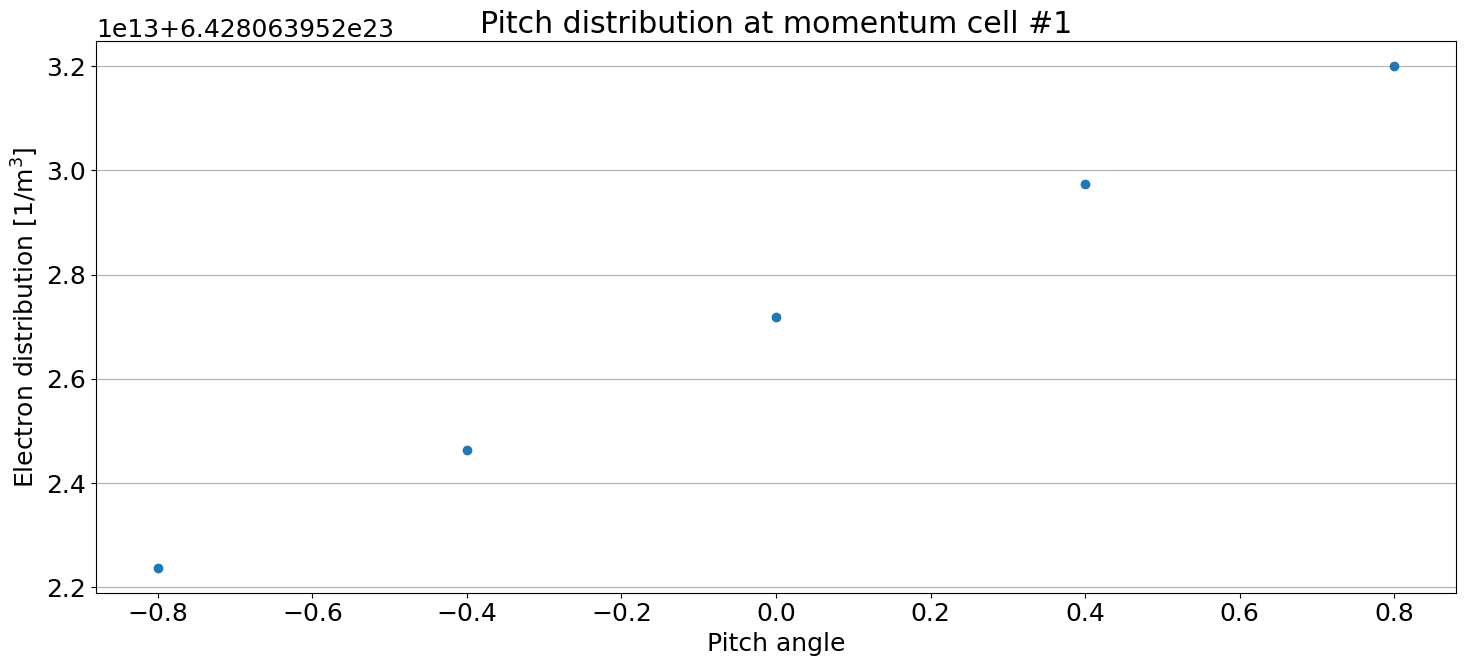

In [227]:
data.plot_pitch_at_specific_momentum(at_timestep=0, at_radial_cell=0, 
                                     momentum_cell=1, save=False)

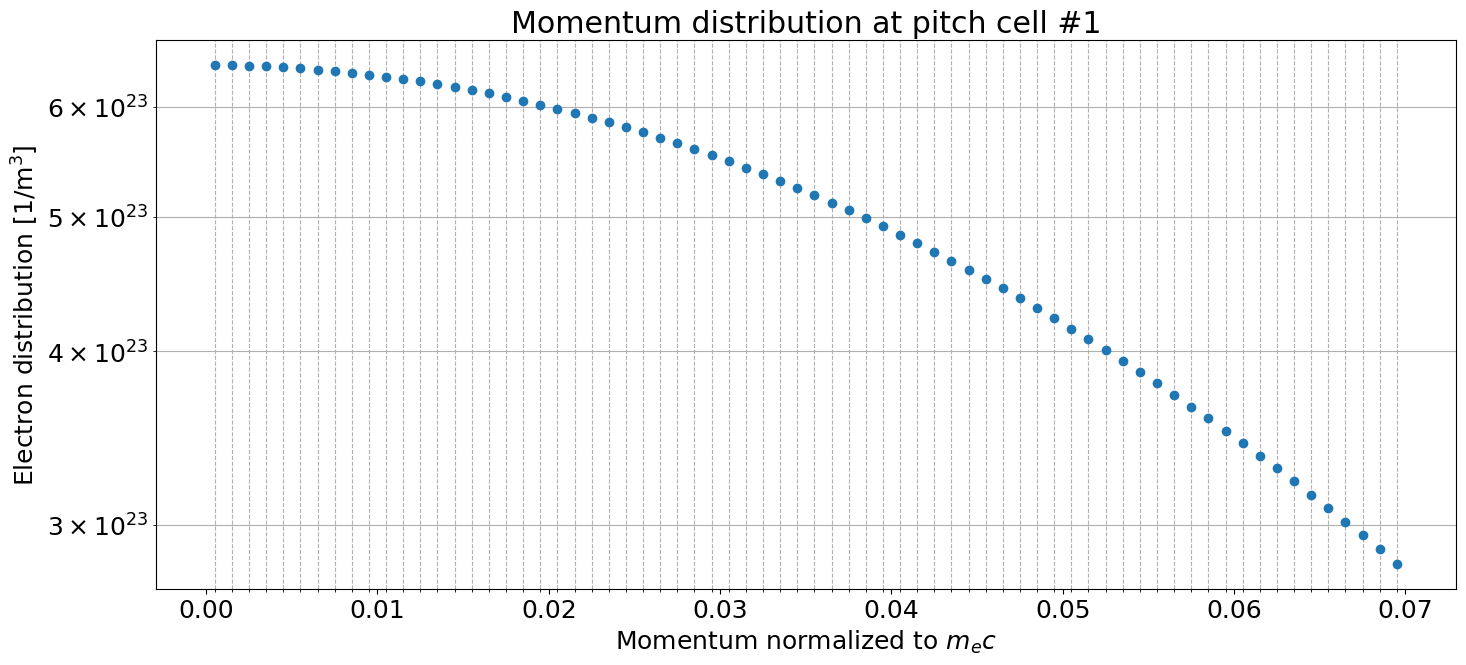

In [228]:
data.plot_momentum_at_specific_pitch(at_timestep=0, at_radial_cell=0, 
                                     from_momentum_cell=0, to_momentum_cell=70, 
                                     pitch_cell=1, save=False)

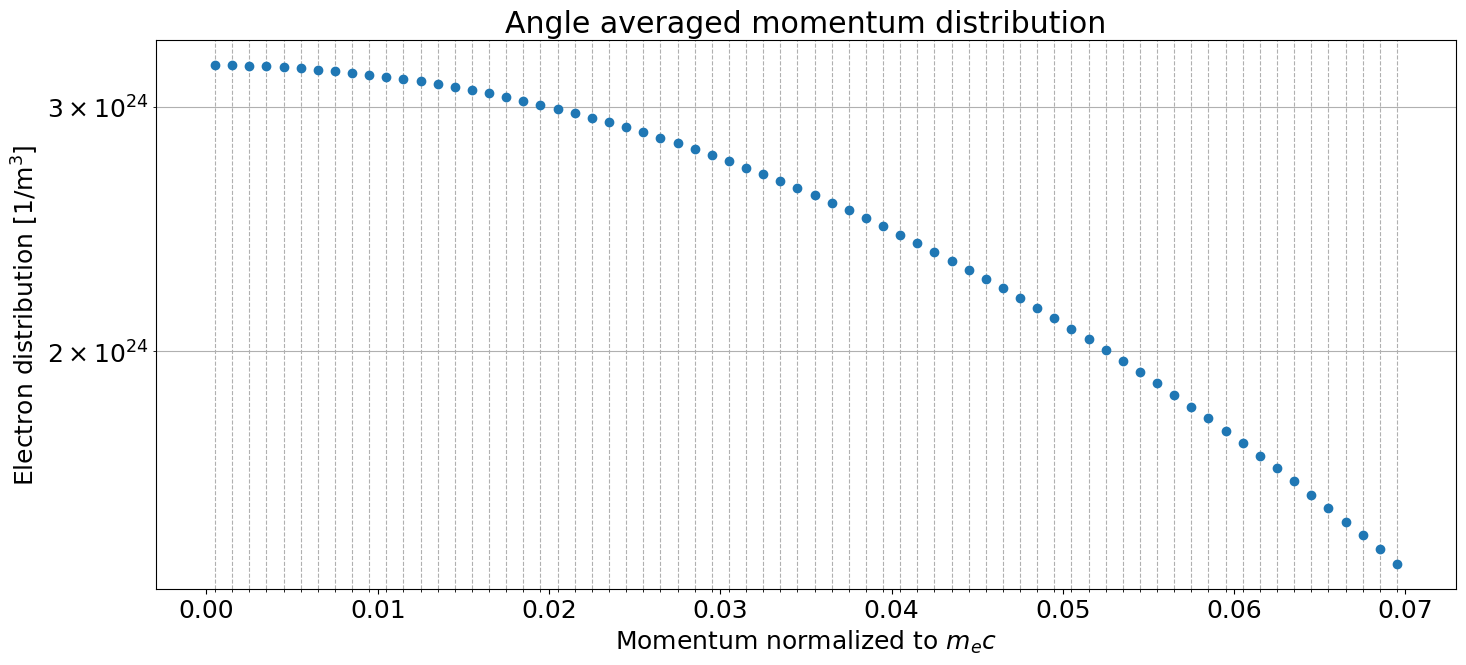

In [229]:
data.plot_angle_avg(at_timestep=0, at_radial_cell=0, from_momentum_cell=0, to_momentum_cell=70, save=False)

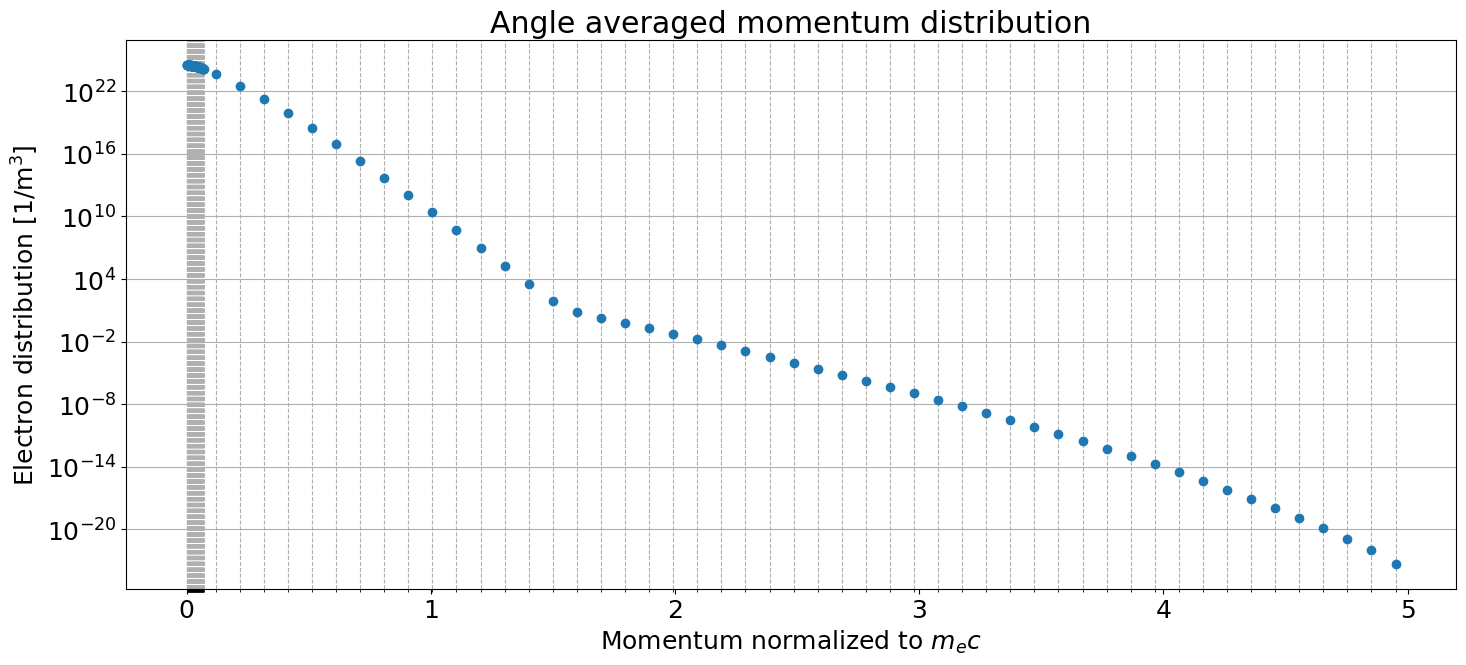

In [230]:
data.plot_angle_avg(at_timestep=0, at_radial_cell=0, from_momentum_cell=0, to_momentum_cell=120, save=False)

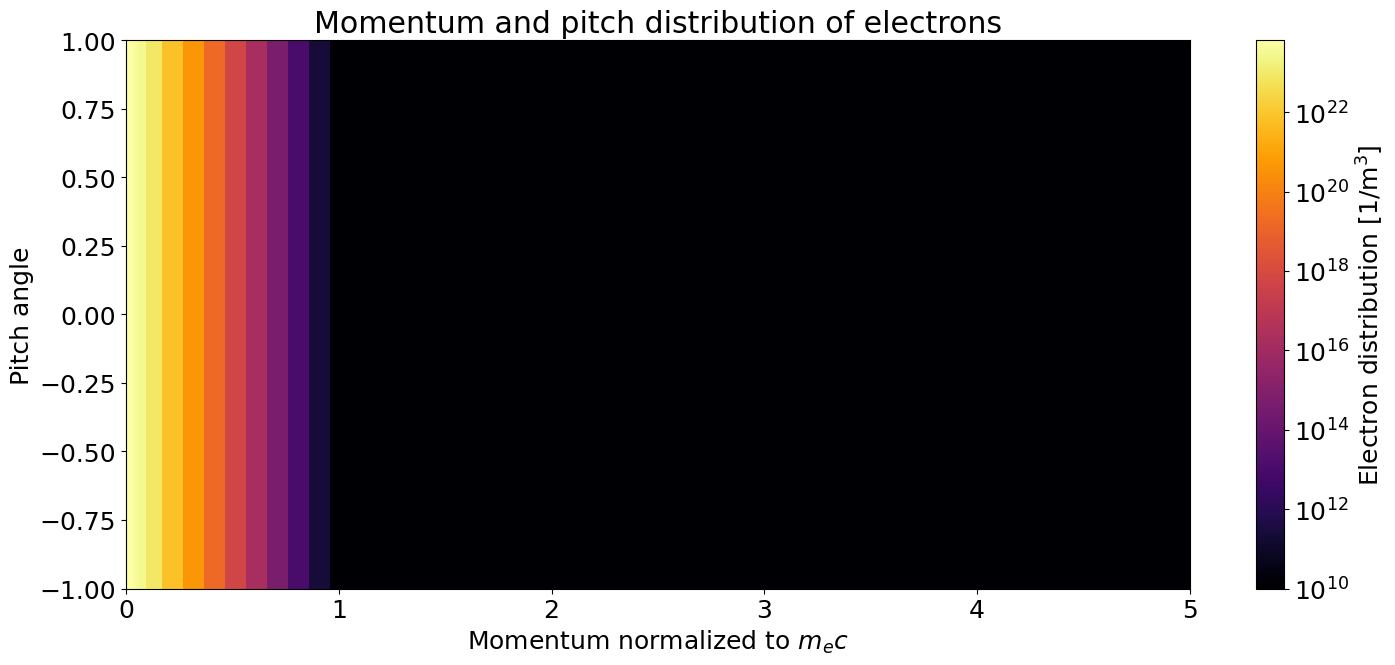

In [231]:
data.plot_2D_momentum(at_timestep=0, at_radial_cell=0, from_momentum_cell=0, to_momentum_cell=120)

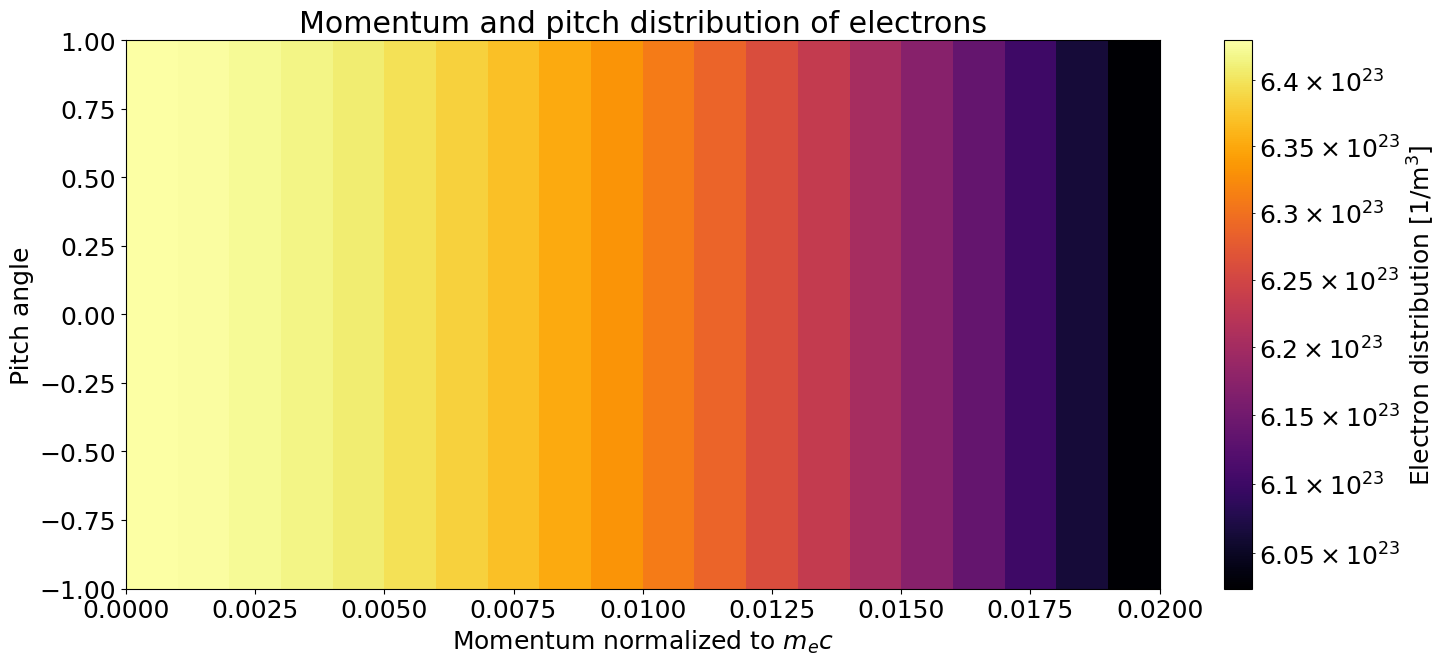

In [233]:
data.plot_2D_momentum(at_timestep=0, at_radial_cell=0, from_momentum_cell=0, to_momentum_cell=20)

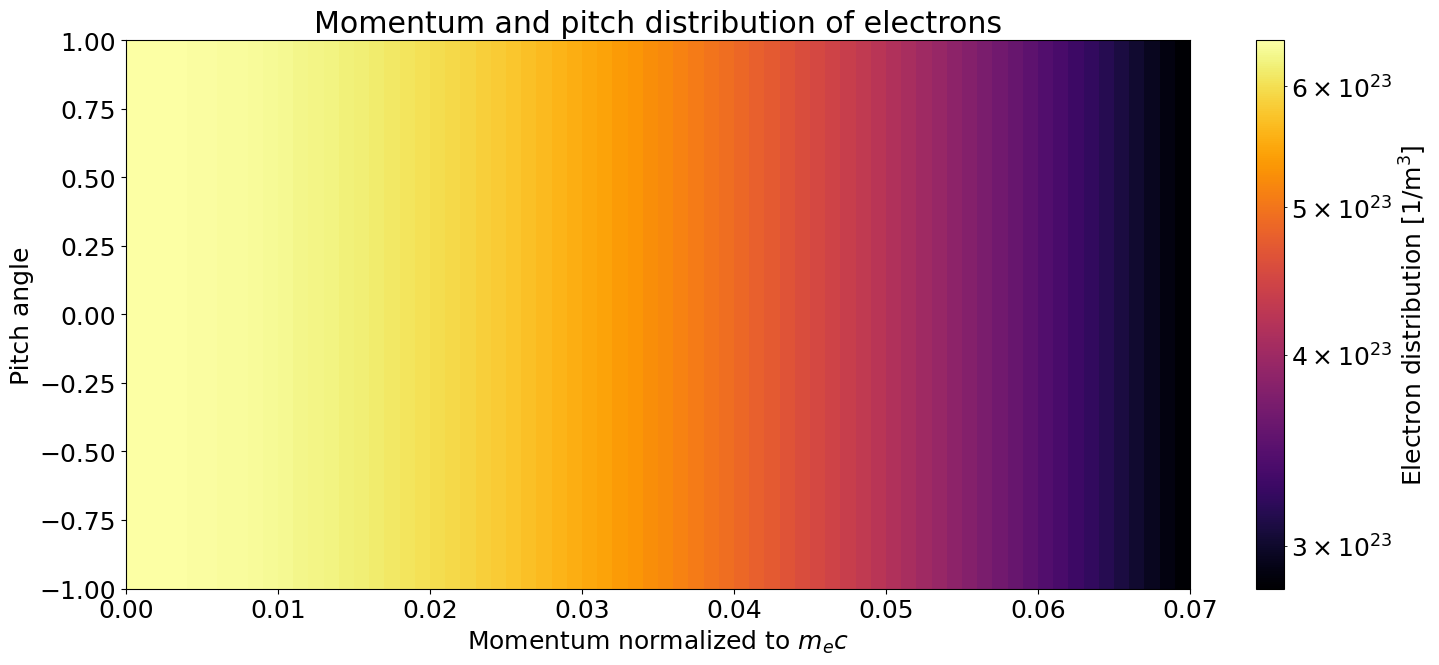

In [239]:
data.plot_2D_momentum(at_timestep=0, at_radial_cell=0, from_momentum_cell=0, to_momentum_cell=70)

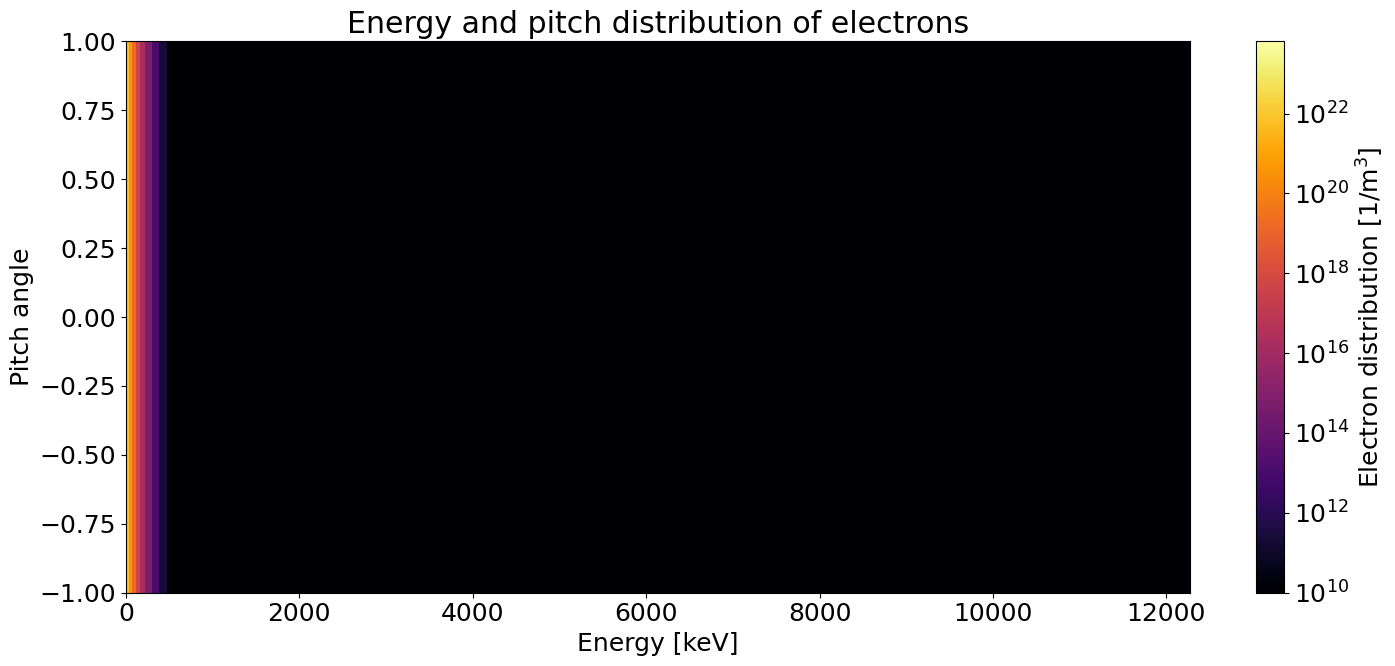

In [232]:
data.plot_2D_energy(at_timestep=0, at_radial_cell=0)

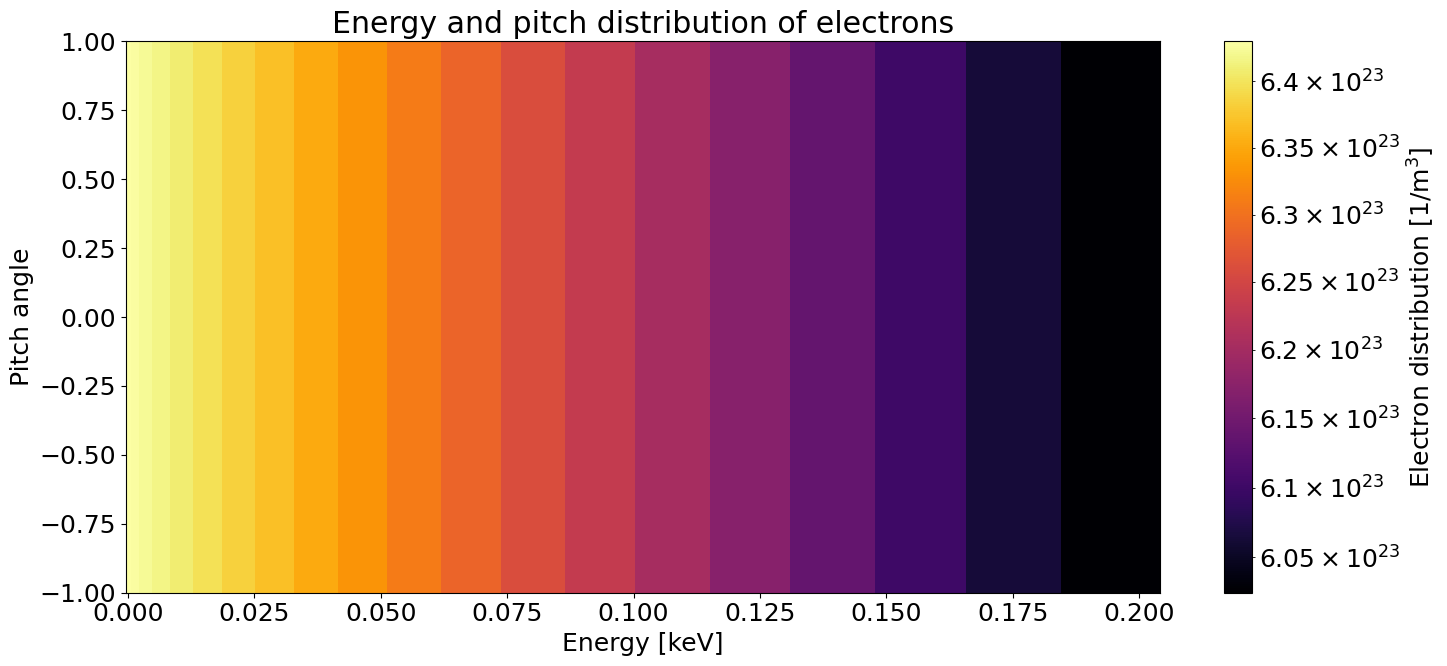

In [240]:
data.plot_2D_energy(at_timestep=0, at_radial_cell=0, from_energy_cell=0, to_energy_cell=20)